In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from scipy.sparse.csgraph import laplacian

pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 286.50it/s]


Using pyvistaqt 3d backend.

Using control points [0.00000000e+00 0.00000000e+00 1.81799519e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


c:\Users\Lukas\Envs\invertenv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


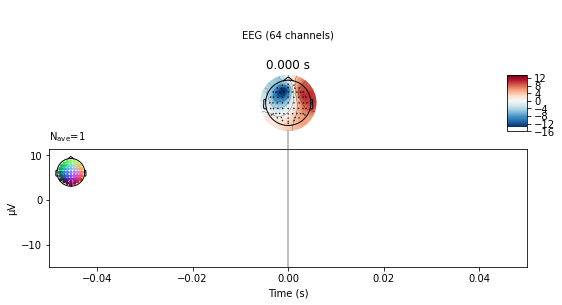

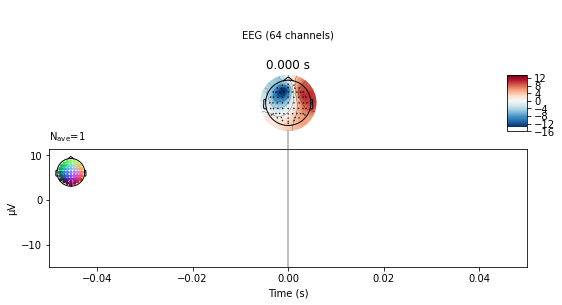

In [3]:
# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=99999999999)
settings = dict(number_of_sources=1, extents=(1, 40), duration_of_trial=0.001, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
y = evoked.data
x = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

## Generator

In [10]:
from invert.solvers import rms, add_white_noise
def generator(fwd, batch_size=1284, batch_repetitions=30, n_sources=2, n_orders=3, amplitude_range=(0.001,1), n_timepoints=20, snr_range=(1, 100), verbose=0):
    adjacency = mne.spatial_src_adjacency(fwd["src"], verbose=verbose).toarray()
    gradient = abs(laplacian(adjacency))
    leadfield = fwd["sol"]["data"]
    leadfield -= leadfield.mean()
    # Normalize columns of the leadfield
    leadfield /= np.linalg.norm(leadfield, axis=0)

    n_chans, n_dipoles = leadfield.shape


    sources = np.identity(n_dipoles)
    for _ in range(n_orders-1):
        new_sources = sources[-n_dipoles:, -n_dipoles:] @ gradient
        new_sources /= new_sources.max(axis=0)
        sources = np.concatenate( [sources, new_sources], axis=0 )

    time_courses = np.stack([np.random.randn(n_timepoints) for _ in range(1000)], axis=0)

    

    n_candidates = sources.shape[0]

    while True:
        # select sources
        n_sources_batch = np.random.randint(1, n_sources+1, batch_size)
        selection = [np.random.randint(0, n_candidates, n) for n in n_sources_batch]

        # Give them a time course
        amplitudes = [time_courses[np.random.choice(np.arange(time_courses.shape[0]), n)].T * np.random.uniform(*amplitude_range, n) for n in n_sources_batch]
        y = np.stack([(amplitudes[i] @ sources[selection[i]]) / len(amplitudes[i]) for i in range(batch_size)], axis=0)
        
        # Project simulated sources through leadfield
        x = np.stack([leadfield @ yy.T for yy in y], axis=0)

        # Add white noise to clean EEG
        snr_levels = np.random.uniform(low=snr_range[0], high=snr_range[1], size=batch_size)
        x = np.stack([add_white_noise(xx, snr_level) for (xx, snr_level) in zip(x, snr_levels)], axis=0)

        # Apply common average reference
        x = np.stack([xx - xx.mean(axis=0) for xx in x], axis=0)
        # Scale eeg
        x = np.stack([xx / np.linalg.norm(xx, axis=0) for xx in x], axis=0)
        x = np.stack([xx / np.max(abs(xx)) for xx in x], axis=0)
        
        x = np.swapaxes(x, 1,2)
        x = x[:, :, :, np.newaxis]
        # Calculate mean source activity
        y = abs(y).mean(axis=1)
        # Masking the source vector (1-> active, 0-> inactive)
        y = (y>0).astype(float)
        
        # Return same batch multiple times:
        for _ in range(batch_repetitions):
            yield (x, y)

gen = generator(fwd, batch_size=1, n_sources=1, n_orders=1,n_timepoints=20, snr_range=(100, 101))
x_test, y_test = gen.__next__()
print(x_test.shape, y_test.shape)
i = 0
%matplotlib qt
evoked_ = mne.EvokedArray(x_test[i, :, :, 0].T, evoked.info)
evoked_.plot_joint(title="Sample")

stc_ = stc.copy()

stc_.data[:, 0] = y_test[i]
stc_.plot(**pp)

(1, 20, 64, 1) (1, 1284)
No projector specified for this dataset. Please consider the method self.add_proj.
Using control points [0.     0.     0.3585]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [0.     0.     0.3585]


# Training

## CNN

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, AveragePooling2D, Activation, Lambda
from tensorflow.keras import backend as K
tf.keras.backend.set_image_data_format('channels_last')

n_channels, n_times = evoked.data.shape
n_dipoles = x.shape[0]

# Architecture Params
n_filters = 64
activation_function = "relu"
batch_size = int(n_dipoles)

# Simulation Params
n_sources = 1
n_orders = 2
n_timepoints = 20
batch_repetitions = 5
snr_range = (1e99, 2e99)
gen_args = dict(batch_size=batch_size, batch_repetitions=batch_repetitions, 
                n_sources=n_sources, n_orders=n_orders, n_timepoints=n_timepoints,
                snr_range=snr_range)


# Training Params
epochs = 100
steps_per_epoch = batch_repetitions

n_hl = 1

inputs = tf.keras.Input(shape=(n_timepoints, n_channels, 1), name='Input')

cnn1 = Conv2D(n_filters, (1, n_channels),
            activation=activation_function, padding="valid",
            name='CNN1')(inputs)
# cnn1 = Lambda(lambda x: K.abs(x))(cnn1)
# reshape = Reshape((n_timepoints, n_filters, 1))(cnn1)
maxpool = AveragePooling2D(pool_size=(n_timepoints, 1), strides=None, padding="valid")(cnn1)
# maxpool = Activation(activation_function)(maxpool)

flat = Flatten()(maxpool)

# flat = Flatten()(cnn1)
# hl1 = Dense(300, 
#             activation=activation_function, 
#             name='HL1')(flat)

out = Dense(n_dipoles, 
            activation="relu", 
            name='Output')(flat)

model = tf.keras.Model(inputs=inputs, outputs=out, name='TemporalCNN')
# model.compile(loss="cosine_similarity", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

model.summary()

gen = generator(fwd, **gen_args)
gen_args["batch_size"] = 256
gen_val = generator(fwd, **gen_args)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=epochs, restore_best_weights=True),]
model.fit(x=gen, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=gen_val.__next__(), callbacks=callbacks)


Model: "TemporalCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 20, 64, 1)]       0         
                                                                 
 CNN1 (Conv2D)               (None, 20, 1, 64)         4160      
                                                                 
 average_pooling2d_1 (Averag  (None, 1, 1, 64)         0         
 ePooling2D)                                                     
                                                                 
 flatten_12 (Flatten)        (None, 64)                0         
                                                                 
 Output (Dense)              (None, 1284)              83460     
                                                                 
Total params: 87,620
Trainable params: 87,620
Non-trainable params: 0
___________________________________________________

KeyboardInterrupt: 

# Eval

In [22]:
clim = dict(kind="percent", lims=(0,0.5,1))
gen_args = dict(batch_size=batch_size, batch_repetitions=batch_repetitions, 
                n_sources=n_sources, n_orders=n_orders, n_timepoints=n_timepoints,
                snr_range=snr_range)
gen_args["batch_size"] = 1
gen_args["amplitude_range"] = (0.99, 1)

gen_tst = generator(fwd, **gen_args)

x_test, y_test = gen_tst.__next__()

y_hat = model.predict(x_test, verbose=0)

stc_ = stc.copy()
stc_.data = (y_test.T / y_test.max( axis=1))
stc_.plot(**pp, brain_kwargs=dict(title="Ground Truths"), colormap="Reds", clim=clim)

stc_ = stc.copy()
stc_.data = (y_hat.T / y_hat.max( axis=1))
stc_.plot(**pp, brain_kwargs=dict(title="Preds"), colormap="Reds", clim=clim)



Using control points [0. 0. 0.]


C:\Users\Lukas\AppData\Local\Temp\ipykernel_3540\2800011684.py:16: RuntimeWarning: All data were zero
  stc_.plot(**pp, brain_kwargs=dict(title="Ground Truths"), colormap="Reds", clim=clim)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Using control points [0. 0. 0.]


C:\Users\Lukas\AppData\Local\Temp\ipykernel_3540\2800011684.py:20: RuntimeWarning: All data were zero
  stc_.plot(**pp, brain_kwargs=dict(title="Preds"), colormap="Reds", clim=clim)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [0.     0.     0.3585]
Using control points [0.09525571 0.12178571 0.67611645]


In [55]:
C = np.random.randn(64, 64)
C = C[np.newaxis, :, :, np.newaxis]
out = model.predict(C)

1/1 [==============================] - 0s 20ms/step


In [61]:
gammas = deepcopy(y_test)
gammas /= gammas.max()
(gammas<0.5).sum()

1282